In [1]:
library(here)
library(here)
library(readr, warn.conflicts = FALSE)
library(arrow, warn.conflicts = FALSE)
library(magrittr, warn.conflicts = FALSE)
library(stringr, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)
library(rlang, warn.conflicts = FALSE)
library(data.table, warn.conflicts = FALSE)
library(lubridate, warn.conflicts = FALSE)
library(tidyr, warn.conflicts = FALSE)
library(truveta.study)
library(dbplyr)
library(ggplot2)

here() starts at /home/jovyan/studyrepositories/hypertensioncohorts-is5fyzbqztbebenalfbuo4boem

Loading required package: DBI


Attaching package: ‘dbplyr’


The following objects are masked from ‘package:dplyr’:

    ident, sql




In [2]:
# build connections 
con <- create_connection()
study <- get_study(con, title = "Hypertension Cohort")
population <- get_population(con, study, title = "Study Cohort")
snapshot <- get_latest_snapshot(con, population, finished = TRUE)

[1] "Deprecation warning: the Vital and SocialHistory tables will be removed from the Truveta Data Model on September 12th, 2023. New snapshots generated after this date will exclude these tables. Existing snapshots which include these tables will be unaffected. Visit Learn for more information."


To sign in to Truveta, use a web browser to open the page https://login.truveta.com/activate?user_code=JTCQ-FHGS.

Signed in successfully.



In [3]:
params = list('missings'=c(0,1067557,1067561))

In [20]:
# number of unique patients in Observation : 1164958

sql <- "select count(distinct PersonId) as patient_count 
from Observation ;
"

load_sql_table(con,snapshot,query = sql) %>% collect()

# number of unique patietns for vital sign obs (should be 1155527)

sql <- "select CategoryConceptId, count(distinct Id) as cnt from Observation
group by CategoryConceptId;
"

load_sql_table(con,snapshot,query = sql) %>% collect() %>% merge(.,concept,by.x= "CategoryConceptId",
                                                                 by.y = "ConceptId",all.x = TRUE)%>%
select(CategoryConceptId, ConceptName, cnt)

patient_count
<int>
1164958


CategoryConceptId,ConceptName,cnt
<dbl>,<chr>,<int>
0,Field has not been mapped,161631
1065644,Flow Sheet,1680075600
1067557,Field is not present in source,3323
1067561,No Information,84
NA,NA,8329012


In [7]:
concept <- read_parquet("data/Concept.parquet")


In [5]:
# missing value distribution of all vital sign types
sql <- " select v.CodeConceptId, c.ConceptName, count(distinct v.Id) as NonMissing
from Vital v join Concept c on (v.CodeConceptId = c.ConceptId)
where Value is not NULL
group by CodeConceptId, ConceptName
order by 1;"

vital_nonmissing <- load_sql_table(con,snapshot, query = sql) %>% collect()

sql2 <- " select v.CodeConceptId, c.ConceptName, count(distinct v.Id) as Missing
from Vital v join Concept c on (v.CodeConceptId = c.ConceptId)
where Value is NULL
group by CodeConceptId, ConceptName
order by 1;"

vital_missing <- load_sql_table(con,snapshot,query = sql2)%>% collect()


vital_nonmissing
vital_missing


CodeConceptId,ConceptName,NonMissing
<int>,<chr>,<int>
773682,Body surface area Derived from formula,16106929
773683,Body weight Measured,9359097
779602,Body height,21188681
779610,Body temperature,58320387
779749,Diastolic blood pressure,9544089
779767,Systolic blood pressure,31652035
780145,Heart rate,118373893
781355,Respiratory rate,68527358
800318,Body weight,13171662


CodeConceptId,ConceptName,Missing
<int>,<chr>,<int>
773682,Body surface area Derived from formula,6563
773683,Body weight Measured,78095
779602,Body height,40846
779610,Body temperature,234487
779749,Diastolic blood pressure,355
779767,Systolic blood pressure,50615
780145,Heart rate,168813
781355,Respiratory rate,97275
800318,Body weight,48559


In [5]:
# encounter type by vital sign type

sql <- "select v.CodeConceptId, e.ClassConceptId, count(distinct v.Id) as NonMissing
from Vital v join Encounter e on (v.EncounterId = e.Id)
where v.Value is not NULL and v.EffectiveDateTime is not NULL
and e.StatusConceptId not in (2983199,2506590,2983200,2506591,2506595)
group by CodeConceptId, ClassConceptId
order by 1,2;"

ev <- load_sql_table(con,snapshot, query = sql) %>% collect()
#ev

In [ ]:
ev_names <- ev %>% merge(.,concept, by.x = "CodeConceptId", by.y = "ConceptId")%>%
select(VitalSignId = CodeConceptId, ClassConceptId, VitalSignName =ConceptName, NonMissing)%>%
merge(.,concept,by.x= 'ClassConceptId',by.y = 'ConceptId')%>%
select(VitalSignId, VitalSignName, EncounterClassId = ClassConceptId, EncounterClassName = ConceptName, NonMissing)

In [14]:
head(ev_names,5)

VitalSignId,VitalSignName,EncounterClassId,EncounterClassName,NonMissing
<int>,<chr>,<int>,<chr>,<int>
773682,Body surface area Derived from formula,0,Field has not been mapped,1
780145,Heart rate,0,Field has not been mapped,493
779767,Systolic blood pressure,0,Field has not been mapped,1289
773683,Body weight Measured,0,Field has not been mapped,1
779749,Diastolic blood pressure,0,Field has not been mapped,174
781355,Respiratory rate,0,Field has not been mapped,138
779602,Body height,0,Field has not been mapped,143
829956,Oxygen saturation in Arterial blood by Pulse oximetry,0,Field has not been mapped,605789
773683,Body weight Measured,1065215,inpatient acute,28


In [16]:
# number of unique encounters for Vital Signs
sql <- "select e.ClassConceptId, count(distinct v.Id) as enct_cnt 
from Vital v left join Encounter e on (v.EncounterId = e.Id)
group by e.ClassConceptId;"

vital_enct <- load_sql_table(con,snapshot, query = sql ) %>% collect()

In [25]:
vital_enct %>% merge(., concept, by.x = "ClassConceptId", by.y = "ConceptId", all.x = TRUE) %>%
select(ClassConceptId, ConceptName, enct_cnt)%>% mutate(percentage =round(enct_cnt/sum(vital_enct$enct_cnt) * 100,3))

ClassConceptId,ConceptName,enct_cnt,percentage
<dbl>,<chr>,<int>,<dbl>
0,Field has not been mapped,23818977,3.631
1065215,inpatient acute,12765,0.002
1065216,ambulatory,170293066,25.956
1065217,emergency,33532123,5.111
1065219,home health,6786775,1.034
1065220,inpatient encounter,248089537,37.814
1065225,observation encounter,16675470,2.542
1065226,pre-admission,58646,0.009
1065227,short stay,14009099,2.135


In [23]:
sum(vital_enct$enct_cnt)

[1] 656074621

In [18]:
#take a glimpse of Vitals
load_sql_table(con,snapshot,query = "select top 5 * from Vital where EncounterId is not NULL;") %>% collect()

CodeConceptId,EffectiveDateTime,EncounterId,Id,InterpretationConceptId,NormalizedValueNumeric,NormalizedValueUOMConceptId,PatientId,RecordedDateTime,StatusConceptId,Value,PersonId
<int>,<dttm>,<chr>,<chr>,<int>,<dbl>,<int>,<chr>,<dttm>,<int>,<chr>,<chr>
773683,2016-04-27 08:57:00,3e1d42ce-3b58-2440-c964-cdb940d8d112,d846b77f-3c12-0f9c-d39c-076d5d1a5fa3,1067557,3491.20,1067561,e65be796-5661-1fc9-9892-e0082738bb6c,2016-04-27 08:57:00,1065715,3491.2,efbe7483-34f9-22c5-b962-d7354a6a519e
809891,2020-04-05 09:52:00,826255d8-1407-90c3-6c6e-b64f888f3dd6,af743c93-7fa7-b0e9-8034-02fa039a48ca,1067557,27.95,1067561,e65be796-5661-1fc9-9892-e0082738bb6c,2020-04-05 09:51:00,1065715,27.95,efbe7483-34f9-22c5-b962-d7354a6a519e
773683,2019-12-15 07:32:00,1a636481-0c4c-ec6f-2f27-2185354498c6,ad07f57e-9b28-2a78-271a-053ec6f4d2d6,1067557,3248.00,1067561,e65be796-5661-1fc9-9892-e0082738bb6c,2019-12-15 07:31:00,1065715,3248,efbe7483-34f9-22c5-b962-d7354a6a519e
780145,2015-10-21 08:47:00,f3edc38d-229f-48ec-076b-42c4a2b6dec1,885c8914-4b33-b8cd-222a-9310b110e2f9,1067557,76.00,1067561,e65be796-5661-1fc9-9892-e0082738bb6c,2015-10-21 08:40:00,1065715,76,efbe7483-34f9-22c5-b962-d7354a6a519e
773682,2017-06-17 11:32:00,540106da-0531-5ed0-13fd-77c29debaef9,59171623-eba3-8f8f-c06e-84960bf6634d,1067557,2.12,1067561,e65be796-5661-1fc9-9892-e0082738bb6c,2017-06-17 11:30:00,1065715,2.12,efbe7483-34f9-22c5-b962-d7354a6a519e


In [17]:
load_sql_table(con,snapshot,query = "select top 5 * from Encounter;") %>% collect()

ClassConceptId,DischargeDispositionConceptId,EndDateTime,Id,LocationId,PatientId,PriorityConceptId,StartDateTime,StatusConceptId,TypeConceptId,PersonId
<int>,<int>,<dttm>,<chr>,<???>,<chr>,<int>,<dttm>,<int>,<int>,<chr>
1065220,1065239,2019-11-12 23:59:00,c4c96584-8cc3-9308-3dff-1f7a8c87ddb2,NA,9437a75d-10ba-f4aa-688d-ff238f7813a3,1067557,2019-11-12 10:50:59,2506592,3059272,c1c3b47e-1f99-df88-ada2-ea35bb499d3a
2649591,1067561,NA,a1a7c588-c9af-3660-64d6-4ac343e4bd05,NA,9437a75d-10ba-f4aa-688d-ff238f7813a3,1067557,2017-04-23 00:00:00,2506592,3059269,c1c3b47e-1f99-df88-ada2-ea35bb499d3a
1065217,1065239,2020-04-03 09:39:00,f38b03f9-80c3-9ea3-0150-607b1cec6a96,NA,9437a75d-10ba-f4aa-688d-ff238f7813a3,1067557,2020-04-03 09:22:00,2506592,3059272,c1c3b47e-1f99-df88-ada2-ea35bb499d3a
1065217,1065239,2020-03-28 20:26:00,4906df98-51d6-8710-22c3-c9f49ec5947a,NA,9437a75d-10ba-f4aa-688d-ff238f7813a3,1067557,2020-03-28 17:17:00,2506592,3059272,c1c3b47e-1f99-df88-ada2-ea35bb499d3a
1065220,1065239,2017-04-27 14:50:00,6de5b37e-86de-561f-3e0a-991d91477dfc,NA,9437a75d-10ba-f4aa-688d-ff238f7813a3,1067557,2017-04-24 02:25:00,2506592,3059272,c1c3b47e-1f99-df88-ada2-ea35bb499d3a


In [10]:
sql <- " select v.CodeConceptId, count(distinct v.EncounterId) as cnt 
from Observation v join Encounter e on (v.EncounterId = e.Id)
where e.ClassConceptId = '1065216'
group by v.CodeConceptId;
"

amb_enct <- load_sql_table(con,snapshot, query = sql) %>% collect()

In [13]:
vital_concept_count <- amb_enct %>% merge(., concept, by.x = "CodeConceptId", by.y = 'ConceptId', all.x = TRUE)%>%
select(CodeConceptId, ConceptName, cnt)

In [71]:
x <- sum(amb_enct$cnt)
y <- x / 1155527

In [72]:
print(x)
print("average # of amb vital measurement is ")
print(y)

[1] 100456753
[1] "average # of amb vital measurement is "
[1] 86.93588


In [11]:
sql <-" select v.StatusConceptId, count(*) as cnt 
from Vital v join Encounter e on (v.EncounterId = e.Id)
where e.ClassConceptId = '1065216'
group by v.StatusConceptId;
"

status_vt <- load_sql_table(con,snapshot, query = sql) %>% collect()
status_vt %>% merge(.,concep, by.x = 'StatusConceptId', by.y = 'ConceptId')%>%
select(StatusConceptId, ConceptName, cnt)

StatusConceptId,ConceptName,cnt
<int>,<chr>,<int>
0,Field has not been mapped,1796249
1065711,Amended,15282
1065715,Final,41028047
1065719,Incomplete,356
1065720,Unknown,6
1067557,Field is not present in source,126781003
1067561,No Information,21496
1205374,Normal,5421
2649591,Insufficient Information,645206


In [4]:
#get cleaned body weight and height vital data in ambulatory
param1 = list( ClassConcept=1065220) # inpatient
param2 = list( ClassConcept=1065216) #outpatient
sql1 <- "select 
v.*, e.ClassConceptId
from Vital v join Encounter e on (v.EncounterId = e.Id)
where e.ClassConceptId = :ClassConcept and v.CodeConceptId in (773683,779602,800318)
and v.NormalizedValueNumeric is not NULL
and NormalizedValueUOMConceptId not in (0,1067557,1067561)
and v.EffectiveDateTime is not NULL;
"
sql2 <- "select 
v.*, e.ClassConceptId
from Vital v join Encounter e on (v.EncounterId = e.Id)
where e.ClassConceptId = :ClassConcept and v.CodeConceptId in (773683,779602,800318)
and v.NormalizedValueNumeric is not NULL
and NormalizedValueUOMConceptId not in (0,1067557,1067561)
and v.EffectiveDateTime is not NULL;
"
inpatient_bw_bh_vital <- load_sql_table(con,snapshot,query = sql1,params = param1) %>% collect()
amb__bw_bh_vital <- load_sql_table(con,snapshot, query = sql2,params = param2) %>% collect()


In [5]:
#get cleaned normalized body height data
inpatient_bh = inpatient_bw_bh_vital%>% filter(CodeConceptId == 779602)
#get cleaned body weight data 
inpatient_bw = inpatient_bw_bh_vital%>% filter(CodeConceptId !=779602)
#get cleaned body height ambulatory data
amb_bh = amb__bw_bh_vital%>% filter(CodeConceptId == 779602)
#get cleaned body weight ambulatory data
amb_bw = amb__bw_bh_vital%>% filter(CodeConceptId != 779602)


In [14]:
# count number of measurements for each patient in patient
inpatient_bh %>% group_by(PatientId) %>% summarise(counts = n_distinct(Id))%>% mutate(sd = sd(counts))%>% summary()
inpatient_bw %>% group_by(PatientId) %>% summarise(counts = n_distinct(Id))%>% mutate(sd = sd(counts)) %>% summary()

  PatientId             counts              sd       
 Length:43712       Min.   :   1.00   Min.   :46.19  
 Class :character   1st Qu.:   7.00   1st Qu.:46.19  
 Mode  :character   Median :  12.00   Median :46.19  
                    Mean   :  23.91   Mean   :46.19  
                    3rd Qu.:  27.00   3rd Qu.:46.19  
                    Max.   :2863.00   Max.   :46.19  

  PatientId             counts              sd       
 Length:62456       Min.   :   1.00   Min.   :40.16  
 Class :character   1st Qu.:   3.00   1st Qu.:40.16  
 Mode  :character   Median :   6.00   Median :40.16  
                    Mean   :  16.23   Mean   :40.16  
                    3rd Qu.:  15.00   3rd Qu.:40.16  
                    Max.   :4161.00   Max.   :40.16  

In [34]:
inpatient_bh %>% merge(.,concept,by.x = 'NormalizedValueUOMConceptId', by.y = 'ConceptId') %>%
mutate(CMValue = case_when(ConceptName == "foot(US)" ~ NormalizedValueNumeric*30.48,
                          ConceptName == "inch(US)" ~ NormalizedValueNumeric*2.54,
                          ConceptName == "inch(international)" ~ NormalizedValueNumeric*2.54,
                          TRUE ~ NormalizedValueNumeric))%>%summarise( cnt = n(),
                                    mean = mean(CMValue),
                                    min = min(CMValue),
                                    qr1 = quantile(CMValue,0.25),
                                    median = quantile(CMValue,0.5),
                                    qr3 = quantile(CMValue,0.75),
                                    max = max(CMValue),
                                    sd = sd(CMValue))


cnt,mean,min,qr1,median,qr3,max,sd
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1044954,77.97726,-2,5,63,162.56,3657.6,79.9338


In [20]:
# distribution of measures
# inpatient body height
inpatient_bh %>% merge(.,concept,by.x = 'NormalizedValueUOMConceptId', by.y = 'ConceptId') %>%
group_by(ConceptName) %>% summarise( cnt = n(),
                                    mean = mean(NormalizedValueNumeric),
                                    min = min(NormalizedValueNumeric),
                                    qr1 = quantile(NormalizedValueNumeric,0.25),
                                    median = quantile(NormalizedValueNumeric,0.5),
                                    qr3 = quantile(NormalizedValueNumeric,0.75),
                                    max = max(NormalizedValueNumeric),
                                    sd = sd(NormalizedValueNumeric))

# inpatient body weight
inpatient_bw %>% merge(.,concept,by.x = 'NormalizedValueUOMConceptId', by.y = 'ConceptId') %>%
group_by(ConceptName) %>% summarise( cnt = n(),
                                    mean = mean(NormalizedValueNumeric),
                                    min = min(NormalizedValueNumeric),
                                    qr1 = quantile(NormalizedValueNumeric,0.25),
                                    median = quantile(NormalizedValueNumeric,0.5),
                                    qr3 = quantile(NormalizedValueNumeric,0.75),
                                    max = max(NormalizedValueNumeric),
                                    sd = sd(NormalizedValueNumeric))

# ambulatory body weight
amb_bw %>% merge(.,concept,by.x = 'NormalizedValueUOMConceptId', by.y = 'ConceptId') %>%
group_by(ConceptName) %>% summarise( cnt = n(),
                                    mean = mean(NormalizedValueNumeric),
                                    min = min(NormalizedValueNumeric),
                                    qr1 = quantile(NormalizedValueNumeric,0.25),
                                    median = quantile(NormalizedValueNumeric,0.5),
                                    qr3 = quantile(NormalizedValueNumeric,0.75),
                                    max = max(NormalizedValueNumeric),
                                    sd = sd(NormalizedValueNumeric))

# inpatient body height
amb_bh %>% merge(.,concept,by.x = 'NormalizedValueUOMConceptId', by.y = 'ConceptId') %>%
group_by(ConceptName) %>% summarise( cnt = n(),
                                    mean = mean(NormalizedValueNumeric),
                                    min = min(NormalizedValueNumeric),
                                    qr1 = quantile(NormalizedValueNumeric,0.25),
                                    median = quantile(NormalizedValueNumeric,0.5),
                                    qr3 = quantile(NormalizedValueNumeric,0.75),
                                    max = max(NormalizedValueNumeric),
                                    sd = sd(NormalizedValueNumeric))

ConceptName,cnt,mean,min,qr1,median,qr3,max,sd
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
centimeter,398092,169.144787,0,160.02,167.64,175.260,3657.600,44.690737
foot (US),275855,5.096319,0,5.00,5.00,5.000,99.000,1.148621
inch (US),34,68.070294,61,65.00,68.00,70.375,74.016,3.603238
inch (international),370973,34.340232,-2,5.00,11.00,65.000,995.000,32.868854


ConceptName,cnt,mean,min,qr1,median,qr3,max,sd
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
centimeter,1675,2.104669,0.000,0.000,0.500,2.500,100.0,4.995977
gram,1641,1907.457166,0.000,1950.000,2000.000,2200.000,5500.0,646.193014
kilogram,594573,85.785031,-5.500,67.300,81.646,99.800,986.0,30.049980
ounce (avoirdupois),1464,3089.420505,0.099,2525.315,3025.600,3598.432,18894.4,923.043932
pound (US and British),414615,180.822039,0.000,142.000,172.000,209.700,2173.8,59.845118


ConceptName,cnt,mean,min,qr1,median,qr3,max,sd
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
centimeter,109,2.174771,0.00,0,1.0,3.00,15.0,2.840095
gram,68,1798.307353,2.00,2000,2000.0,2251.25,3100.0,894.100759
kilogram,55650,88.054171,-99.30,71,84.9,101.15,991.7,28.137040
ounce (avoirdupois),13063,3309.142134,176.37,2704,3200.0,3795.20,9600.0,829.658305
pound (US and British),15433,191.283940,0.00,155,185.4,220.70,2162.8,59.685461


ConceptName,cnt,mean,min,qr1,median,qr3,max,sd
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
centimeter,88278,167.700986,0.000,160.02,166.37,175.26,2658.11,47.408299
foot (US),56206,5.103316,0.000,5.00,5.00,5.00,71.00,1.230119
inch (US),554,67.014605,24.114,65.00,67.00,70.00,74.00,4.214071
inch (international),429402,128.853548,0.000,61.00,65.00,68.50,300564.00,4516.234452


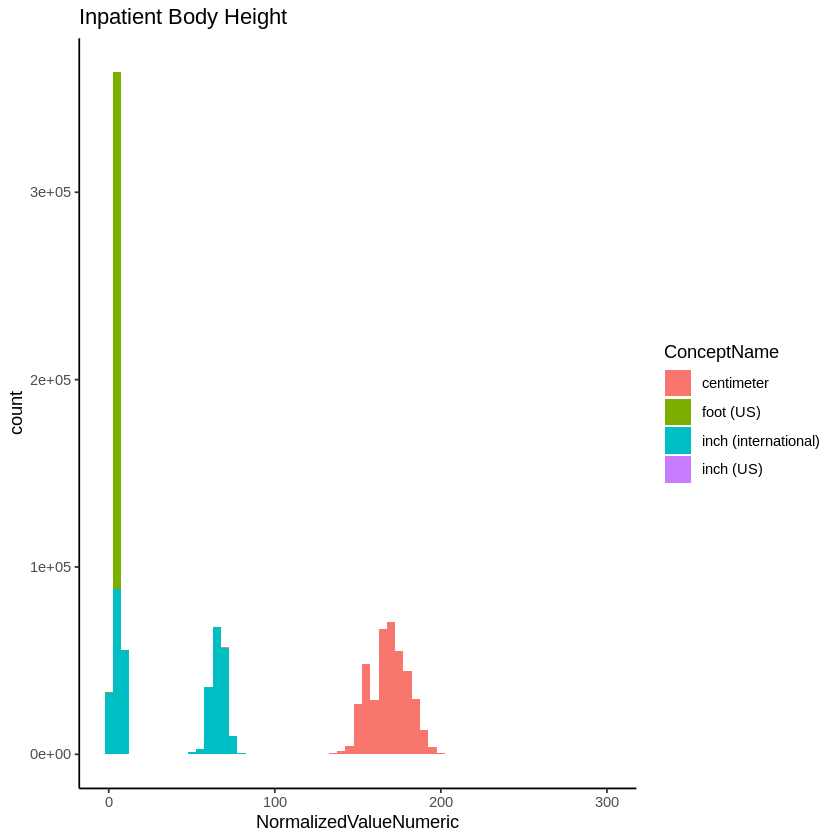

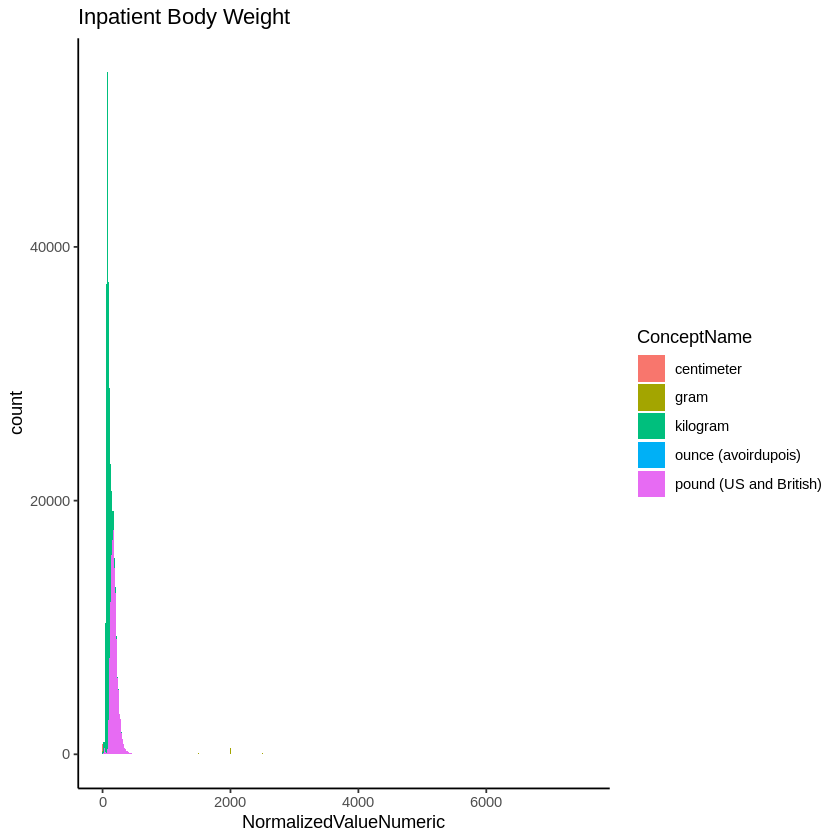

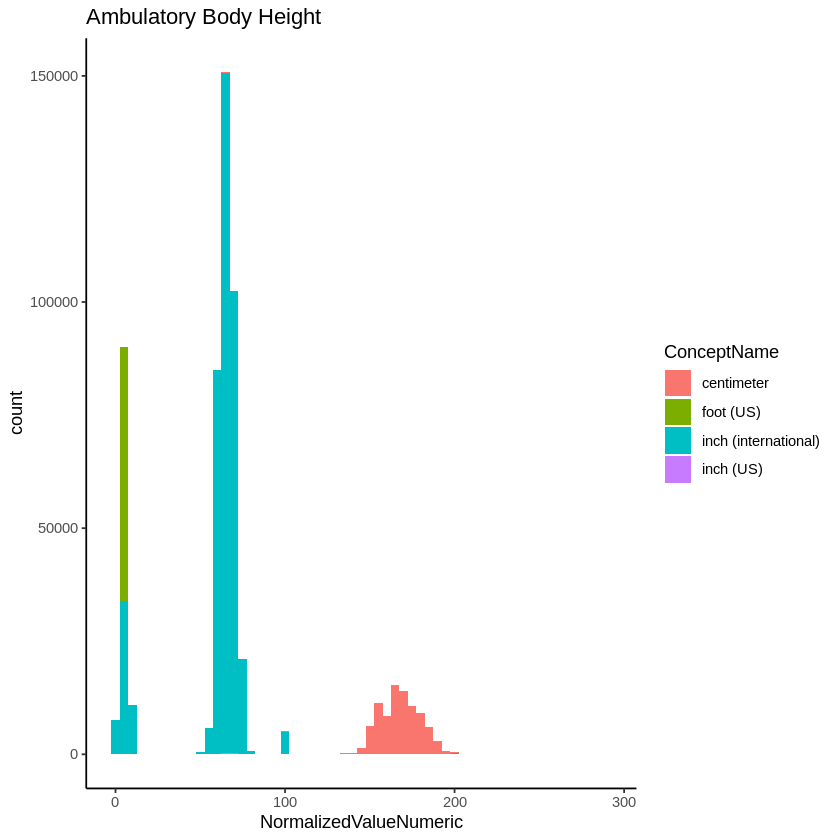

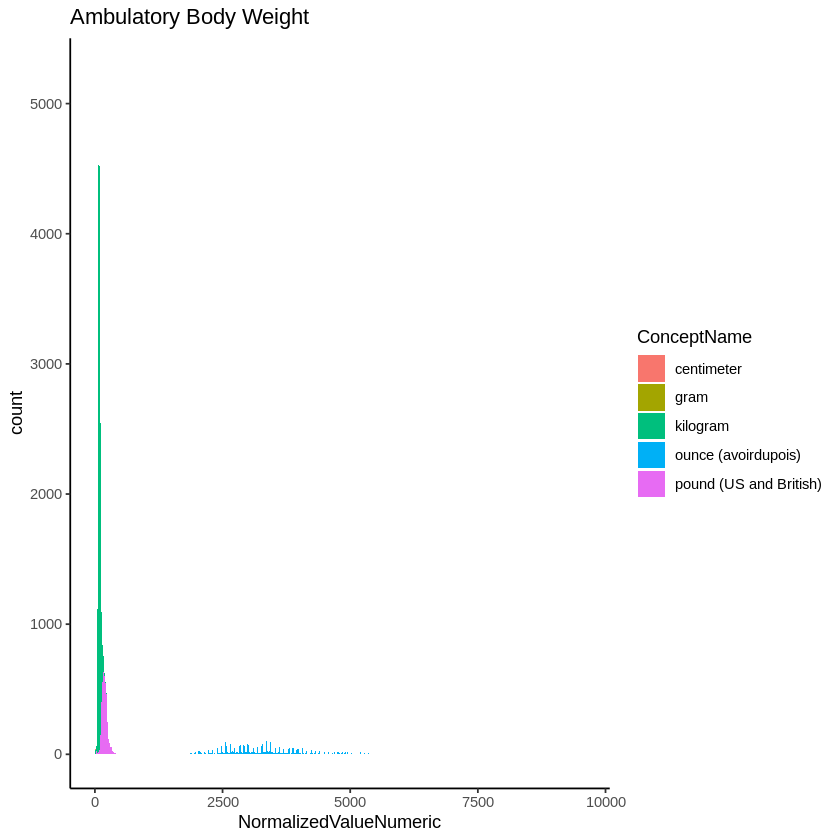

In [8]:
# plot histograms for cm and kg values
inpatient_bh %>%filter(NormalizedValueNumeric > 0 & NormalizedValueNumeric < 300) %>%
merge(.,concept,by.x = 'NormalizedValueUOMConceptId', by.y = 'ConceptId') %>%
ggplot(., aes(x = NormalizedValueNumeric, fill=ConceptName)) + geom_histogram(binwidth = 5)+theme_classic()+ ggtitle("Inpatient Body Height")

inpatient_bw %>%filter(NormalizedValueNumeric > 0 & NormalizedValueNumeric < 10000) %>%
merge(.,concept,by.x = 'NormalizedValueUOMConceptId', by.y = 'ConceptId') %>%
ggplot(., aes(x = NormalizedValueNumeric, fill=ConceptName)) + geom_histogram(binwidth = 5)+theme_classic()+ ggtitle("Inpatient Body Weight")

#plot historgram for inpatient values
amb_bh %>%filter(NormalizedValueNumeric > 0 & NormalizedValueNumeric < 300) %>%
merge(.,concept,by.x = 'NormalizedValueUOMConceptId', by.y = 'ConceptId') %>%
ggplot(., aes(x = NormalizedValueNumeric, fill=ConceptName)) + geom_histogram(binwidth = 5)+theme_classic()+ ggtitle("Ambulatory Body Height")

amb_bw %>%filter(NormalizedValueNumeric > 0 & NormalizedValueNumeric < 10000) %>%
merge(.,concept,by.x = 'NormalizedValueUOMConceptId', by.y = 'ConceptId') %>%
ggplot(., aes(x = NormalizedValueNumeric, fill=ConceptName)) + geom_histogram(binwidth = 5)+theme_classic()+ ggtitle("Ambulatory Body Weight")

In [39]:
#exam data availability: null values, categories, counts.
#1. null values and units
bw_unit <- amb_vital%>% filter(is.na(NormalizedValueNumeric)) %>% 
group_by(CodeConceptId,NormalizedValueUOMConceptId)%>%
summarise( cnt = n())%>%
merge(.,concep, by.x = "NormalizedValueUOMConceptId", by.y = "ConceptId")%>%
merge(.,concep,by.x  = 'CodeConceptId', by.y = 'ConceptId')%>%
select(CodeConceptId,UnitsId =NormalizedValueUOMConceptId, VitalType = ConceptName.y, UnitName = ConceptName.x, cnt)%>%arrange(CodeConceptId)

`summarise()` has grouped output by 'CodeConceptId'. You can override using the
`.groups` argument.


In [40]:
bw_unit

CodeConceptId,UnitsId,VitalType,UnitName,cnt
<int>,<int>,<chr>,<chr>,<int>
773683,0,Body weight Measured,Field has not been mapped,3
773683,1190347,Body weight Measured,ounce (avoirdupois),5087003
773683,1067561,Body weight Measured,No Information,65218
773683,1067557,Body weight Measured,Field is not present in source,674
773683,1207160,Body weight Measured,pound (US and British),3
773683,1190497,Body weight Measured,kilogram,1
779602,0,Body height,Field has not been mapped,84
779602,1067561,Body height,No Information,25632
779602,1067557,Body height,Field is not present in source,388


In [41]:
# total counts 
amb_vital%>%
group_by(CodeConceptId,NormalizedValueUOMConceptId)%>%
summarise( cnt = n())%>%
merge(.,concep, by.x = "NormalizedValueUOMConceptId", by.y = "ConceptId")%>%
merge(.,concep,by.x  = 'CodeConceptId', by.y = 'ConceptId')%>%
select(CodeConceptId,UnitsId =NormalizedValueUOMConceptId, VitalType = ConceptName.y, UnitName = ConceptName.x, cnt)%>%arrange(CodeConceptId)

`summarise()` has grouped output by 'CodeConceptId'. You can override using the
`.groups` argument.


CodeConceptId,UnitsId,VitalType,UnitName,cnt
<int>,<int>,<chr>,<chr>,<int>
773683,0,Body weight Measured,Field has not been mapped,22206
773683,1190497,Body weight Measured,kilogram,111782
773683,1189977,Body weight Measured,gram,5
773683,1067557,Body weight Measured,Field is not present in source,208062
773683,1190347,Body weight Measured,ounce (avoirdupois),6225486
773683,1067561,Body weight Measured,No Information,5734025
773683,1207160,Body weight Measured,pound (US and British),432527
779602,0,Body height,Field has not been mapped,50043
779602,1067561,Body height,No Information,9500759


In [31]:
#get non-null values for body weight and height respectively

# body weight 
weight_units <- c(1189977,1190497,1207160,1190347)
amb_vital%>%filter(!is.na(NormalizedValueNumeric), CodeConceptId %in% c(800318,773683))%>%filter(NormalizedValueUOMConceptId %in% weight_units)%>%
summarise(unique_patient = n_distinct(PersonId), unique_record = n_distinct(Id))


# body height
height_units <- c(1190010,1190288,1190307,1190310)
amb_vital%>%filter(!is.na(NormalizedValueNumeric), CodeConceptId %in% c(779602))%>%filter(NormalizedValueUOMConceptId %in% height_units)%>%
summarise(unique_patient = n_distinct(PersonId), unique_record = n_distinct(Id))


unique_patient,unique_record
<int>,<int>
106931,1715126


unique_patient,unique_record
<int>,<int>
104901,1419862


In [54]:
bw <- amb_vital%>%filter(!is.na(NormalizedValueNumeric), CodeConceptId %in% c(800318,773683))%>%filter(NormalizedValueUOMConceptId %in% weight_units)

bh <- amb_vital%>%filter(!is.na(NormalizedValueNumeric), CodeConceptId %in% c(779602))%>%filter(NormalizedValueUOMConceptId %in% height_units)

In [59]:
# unique patient counts by year
# get shifted time first
shifted_time = read_parquet("data/absolute_date_time.parquet")
head(shifted_time)

AbsoluteEffectiveDateTime,RecordedDateTime,ResultsTruncated,Id,PersonId
<chr>,<dttm>,<lgl>,<int64>,<chr>
2019-05,2018-01-05 00:00:00,FALSE,4215590831056887621,aaaa8888-1d8b-13ea-9478-5d4a91f3b2e2
2019-07,2018-03-02 00:00:00,FALSE,652398242750907759,aaaa8888-1d8b-13ea-9478-5d4a91f3b2e2
2019-01,2017-05-14 00:00:00,FALSE,4215590831056887621,c9a3b685-bdad-02f0-8ea5-a3a414d57bf1
2019-07,2017-10-30 00:00:00,FALSE,652398242750907759,c9a3b685-bdad-02f0-8ea5-a3a414d57bf1
2019-07,2017-11-20 00:00:00,FALSE,1312270624178065363,c9a3b685-bdad-02f0-8ea5-a3a414d57bf1
2019-07,2017-11-24 04:19:00,FALSE,6698346428589469568,c9a3b685-bdad-02f0-8ea5-a3a414d57bf1


In [61]:
bw %>% mutate(year = format(RecordedDateTime, "%Y"))%>% group_by(year) %>%
summarise(unique_patient = n_distinct(PersonId), unique_record = n_distinct(Id))%>%arrange(desc(year))

year,unique_patient,unique_record
<chr>,<int>,<int>
2022,8751,17568
2021,43529,170895
2020,47698,207195
2019,49333,200441
2018,62529,263073
2017,63552,292502
2016,49615,224477
2015,38897,167734
2014,24759,75743


In [74]:
write_parquet(bw,"data/body_weight_vital.parquet")
write_parquet(bh, "data/body_height_vitla.parquet")

In [52]:
head(person_bod)

...1,PersonId,AbsoluteBirthDate,ShiftedTime
<dbl>,<chr>,<dttm>,<chr>
0,462c6279-ef11-e176-7c57-72c8831ccdea,1975-01-13 00:00:00,520 days 00:00:00
1,8382031e-1324-422d-6020-7c986bf379da,1964-05-28 19:12:00,607 days 19:12:00
2,59e235d8-d171-3c19-a6d0-21532f5c1f96,1974-01-06 00:00:00,464 days 00:00:00
3,33060397-8368-2c37-f090-a8cb34220880,1971-03-30 04:48:00,536 days 04:48:00
4,4c083ab8-85af-7f90-0baf-8fe8b990855c,1959-02-10 12:00:00,660 days 12:00:00
5,85fc206f-3eef-18c0-868e-f836957c33a6,1959-07-09 00:00:00,625 days 00:00:00


In [45]:
#patient-wise statistics
library(ggplot2)

In [65]:
sql3 <- "select v.PersonId, count(*) as cnt
from Vital v join Encounter e on (v.EncounterId = e.Id)
where e.ClassConceptId = '1065216' and v.NormalizedValueNumeric is not NULL
group by v.PersonId
order by cnt;"

person_obs_cnt <- load_sql_table(con,snapshot, query= sql3) %>% collect()

In [68]:
person_obs_cnt%>%arrange(desc(cnt))%>%head(5)

PersonId,cnt
<chr>,<int>
12e66837-cf97-0eb3-21e4-a5b8393e0857,30289
ad3ea0de-5b6a-8f50-1727-89ff3dc30bd5,30047
6ea6bff1-e6b2-b056-03e6-8fc5f6c2f99f,14072
5946e126-f349-9773-dcba-1c0765e6b009,12012
6aa7d8ad-2fd5-034e-870b-561c74a79b24,11266


In [67]:
mean(person_obs_cnt$cnt)

[1] 182.4446

In [70]:
#hear rate data
sql2 <- "select 
v.PersonId as PersonId, v.NormalizedValueUOMConceptId, v.NormalizedValueNumeric, v.
from Vital v join Encounter e on (v.EncounterId = e.Id)
where e.ClassConceptId = '1065216' and v.CodeConceptId =780145;"
hr_vital <- load_sql_table(con,snapshot, query = sql2) %>% collect()
hr_vital %>% group_by(CodeConceptId,NormalizedValueUOMConceptId )%>%summarise(cnt = n())%>%
merge(.,concep, by.x = "NormalizedValueUOMConceptId", by.y = "ConceptId")%>%
merge(.,concep,by.x  = 'CodeConceptId', by.y = 'ConceptId')%>%
select(CodeConceptId,UnitsId =NormalizedValueUOMConceptId, VitalType = ConceptName.y, UnitName = ConceptName.x,cnt)%>%arrange(CodeConceptId)

In [ ]:
# blood pressure data
params = list('CodeConceptId'= c(779749,
779767,
825889))